# Specific game attributes for Jan 16 pilot

In [1]:
%pylab inline
import scipy.stats as stats
import itertools
import pandas as pd
import networkx as nx
from lifelines import CoxTimeVaryingFitter
import json
from collections import Counter
from measure_experiment import *

import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [2]:
export_dir = "/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/detective-game-interdependent-diffusion/results-sensitive/pilot/20200116/Empirica Data - 2020-01-16 17-53-52/"
players = []
with open(export_dir + 'players.json', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.json', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.json', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.json', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'])

0 2019-11-27T18:20:38.972Z
1 2019-12-11T17:08:10.631Z
2 2019-12-11T18:21:08.701Z
3 2019-12-18T15:21:44.815Z
4 2019-12-18T15:58:20.952Z
5 2020-01-16T17:36:13.359Z


In [3]:
loaded_games[-1]['data.gameSetupId']

'panel_1_matched_pair_exp_design5_matched_20191211_112322'

In [4]:
# select which games to process
# Game 1 was a test game, for practice

select = [5]
process_games = [loaded_games[i] for i in select]
for game in process_games:
    print(i, game['createdAt'], game['data.gameSetupId'])

5 2020-01-16T17:36:13.359Z panel_1_matched_pair_exp_design5_matched_20191211_112322


In [5]:
for player_id, player in game['players'].items():
    if 'workerId' in player['urlParams'].keys():
        player['name'] = player['urlParams']['workerId']
    else:
        player['name'] = player['id']

In [6]:
t_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='t']
c_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='c']

In [7]:
t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

game_log = pd.DataFrame(game['log'])
game_log['logTime'] = game_log['createdAt'].apply(lambda s: datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ'))
game_log['t'] = game_log['logTime'] - t_start
game_log

,_id,playerId,gameId,roundId,stageId,name,jsonData,createdAt,data,logTime,t
0,pAqG9sqYkqGZAcKMX,fTfezvB73qTeZ8aK5,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,navigation,"""Pageload""",2020-01-16T17:36:17.551Z,Pageload,2020-01-16 17:36:17.551,00:00:04.192000
1,vkmJE3PD9qDYNYW9o,WWFZgsSi3j9E2KRTa,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,navigation,"""Pageload""",2020-01-16T17:36:17.555Z,Pageload,2020-01-16 17:36:17.555,00:00:04.196000
2,5Z9gfxRnAqxrr5Bs4,oETAgp2uGSb5oMYkd,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,navigation,"""Pageload""",2020-01-16T17:36:17.559Z,Pageload,2020-01-16 17:36:17.559,00:00:04.200000
3,aBe6562CxzCFFyYzh,9g2FHMNtfpW3Ybn7y,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,navigation,"""Pageload""",2020-01-16T17:36:17.565Z,Pageload,2020-01-16 17:36:17.565,00:00:04.206000
4,GdADqPkWTe4eBDRA5,ipbFKp62TwisgajSq,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,navigation,"""Pageload""",2020-01-16T17:36:17.563Z,Pageload,2020-01-16 17:36:17.563,00:00:04.204000
...,...,...,...,...,...,...,...,...,...,...,...
2492,oBnTJt6gB8N2whWax,z8jj7Jkw4H4KTgp3f,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,drop,"{""clue"":""tclue_7_9"",""source"":""WWFZgsSi3j9E2KRT...",2020-01-16T17:44:15.653Z,"{'clue': 'tclue_7_9', 'source': 'WWFZgsSi3j9E2...",2020-01-16 17:44:15.653,00:08:02.294000
2493,hCyz4KaLXRemSXfbQ,9bmCqDYb4BqEBzXTt,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,drop,"{""clue"":""cclue_4_9"",""source"":""dead_ends"",""dest...",2020-01-16T17:44:15.882Z,"{'clue': 'cclue_4_9', 'source': 'dead_ends', '...",2020-01-16 17:44:15.882,00:08:02.523000
2494,Czbyrfo8WwnGFCFD7,E34fQfx9Qev9aru4u,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,pickup,"{""clue"":""tclue_1_3"",""source"":""MgsFNQrBqo9FZF37q""}",2020-01-16T17:44:16.336Z,"{'clue': 'tclue_1_3', 'source': 'MgsFNQrBqo9FZ...",2020-01-16 17:44:16.336,00:08:02.977000
2495,ErsZpaNFWXA4SvkET,ipbFKp62TwisgajSq,dSj3Jn2v4on43sNgf,vx4F5YeTphmqoX2MS,QNg8zqapA4d9xezQC,pickup,"{""clue"":""tclue_3_9"",""source"":""q8BFGzxXAeZb28N4u""}",2020-01-16T17:44:17.475Z,"{'clue': 'tclue_3_9', 'source': 'q8BFGzxXAeZb2...",2020-01-16 17:44:17.475,00:08:04.116000


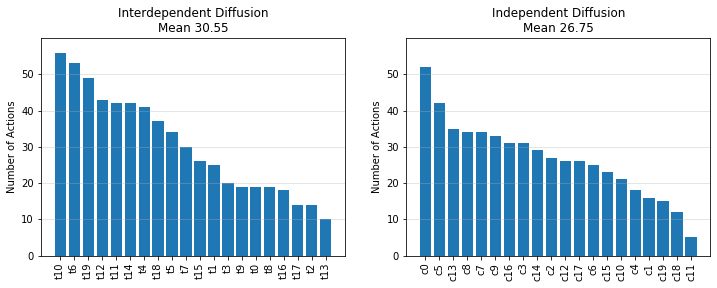

In [8]:
plt.figure(figsize=(12,4))

counts = game_log[game_log['name'] == 'drop'][['playerId', '_id']].groupby('playerId').count()

log_length = {}
for pid in t_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,1)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Interdependent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

log_length = {}
for pid in c_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,2)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Independent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

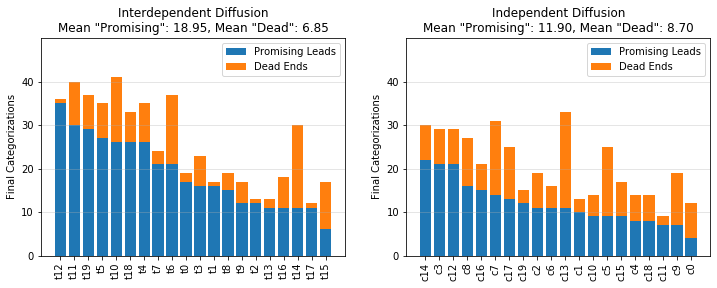

In [9]:
plt.figure(figsize=(12,4))

promising = {}
dead = {}
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,1)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Interdependent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));


promising = {}
dead = {}
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,2)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Independent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));

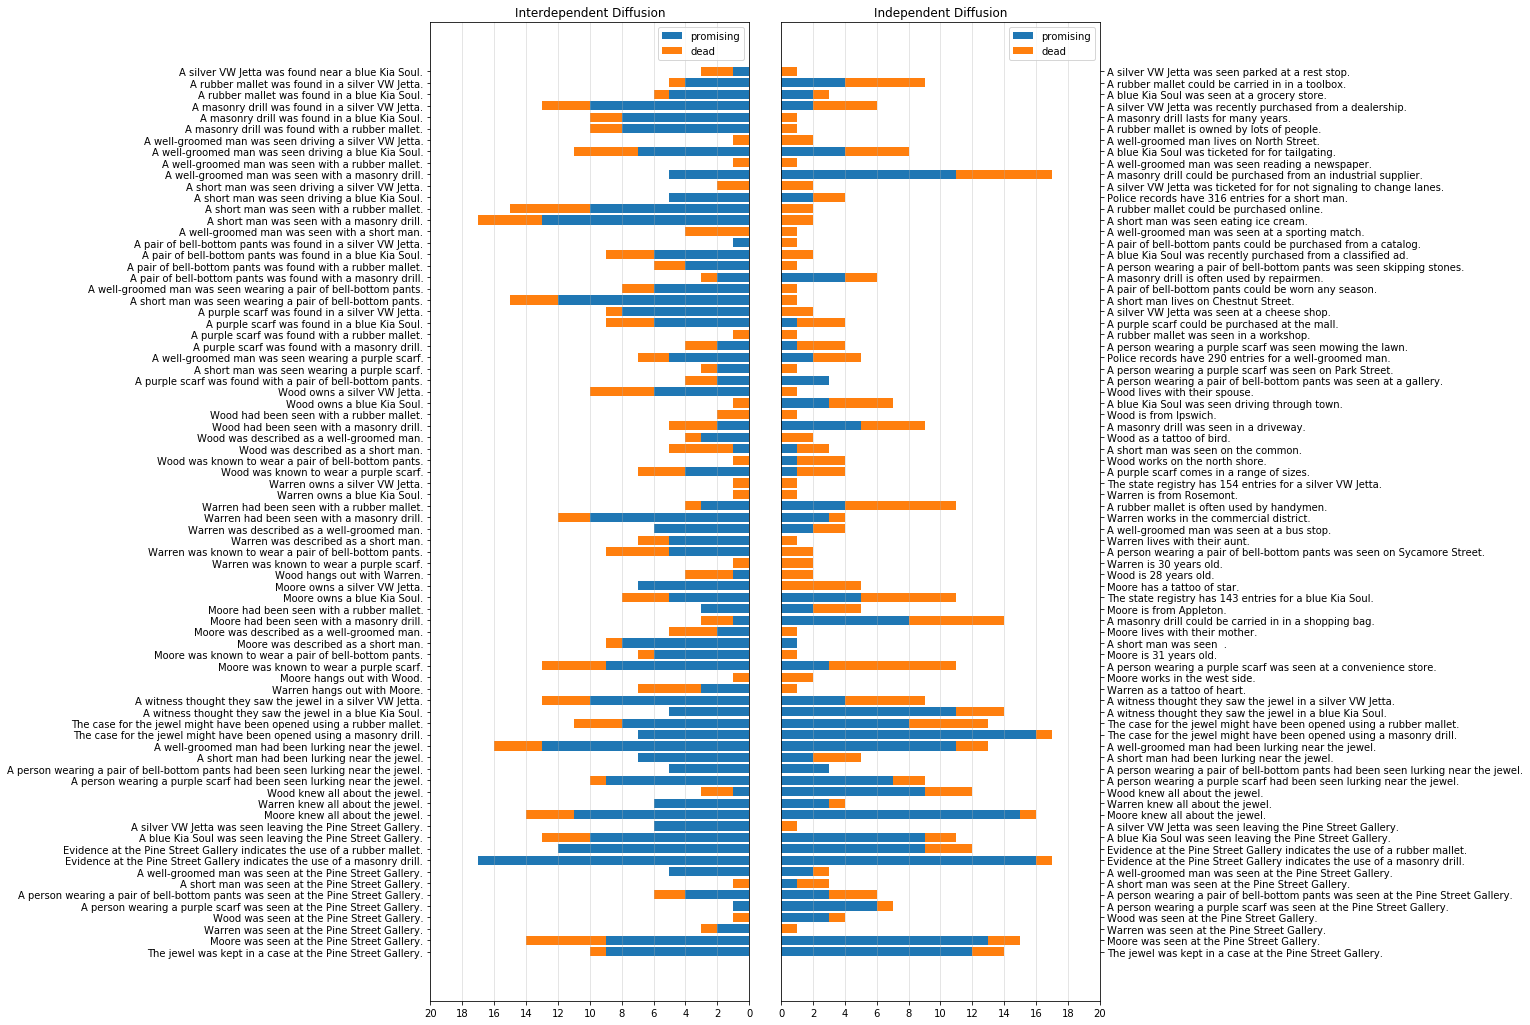

In [10]:

plt.figure(figsize=(12,18))

promising = Counter()
dead = Counter()
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1
            
axl = plt.subplot(1,2,1)       
#order = list(set(promising.keys()).union(set(dead.keys())))
order = [k for k in game['data.clues'].keys() if k[0]=='t']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.box('off')
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.grid('on', axis='x', alpha=.4)
plt.title('Interdependent Diffusion');
axl.invert_xaxis()
inter_promising = promising
inter_order = order

promising = Counter()
dead = Counter()
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1

axr = plt.subplot(1,2,2)       
order = [k for k in game['data.clues'].keys() if k[0]=='c']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.box('off')
plt.grid('on', axis='x', alpha=.4)
plt.title('Independent Diffusion');
axr.yaxis.tick_right()
plt.subplots_adjust(wspace=.1)

indep_promising = promising
indep_order = order

In [16]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in inter_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Treatment: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([inter_promising[cl] for cl in spoke])/23, np.sum([inter_promising[cl] for cl in nonspoke])/55))

spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in indep_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Control: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([indep_promising[cl] for cl in spoke])/23, np.sum([indep_promising[cl] for cl in nonspoke])/55))

Treatment: 6.83 adoptions per spoke, 4.04 adoptions per nonspoke
Control: 7.09 adoptions per spoke, 1.36 adoptions per nonspoke


# idle check

In [11]:
activity = {}
for player_id, player in game['players'].items():
    if 'data.active' in player.keys():
        activity[player['data.position']] = player['data.active']

activity


{'c0': 'idle once',
 't2': 'idle once',
 't8': 'idle once',
 't17': 'idle once',
 't4': 'idle once',
 'c7': 'idle once',
 'c18': 'idle once',
 't3': 'idle once',
 'c19': 'idle once',
 'c10': 'idle once'}

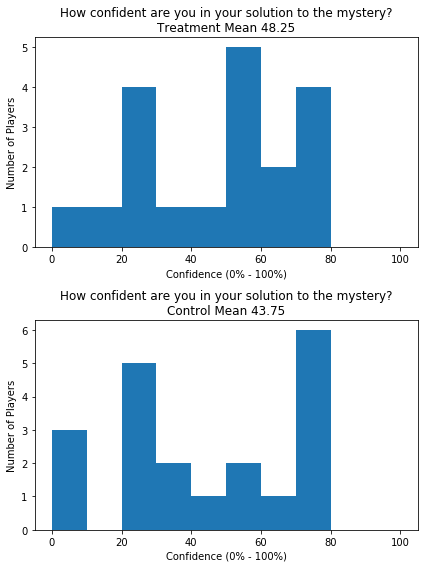

In [12]:
plt.figure(figsize=(6,8))

confidences = []
consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,1)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nTreatment Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)

confidences = []
consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,2)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nControl Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('confidence.png', transparent=True, dpi=500, bbox_inches='tight')



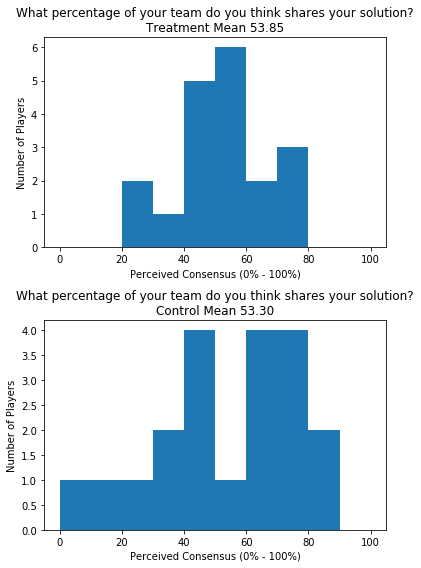

In [13]:
plt.figure(figsize=(6,8))


consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,1)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nTreatment Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)


consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,2)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nControl Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('consensus.png', transparent=True, dpi=500, bbox_inches='tight')


In [14]:
import string
fair = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'fair' in player['data.survey'].keys():
            s = player['data.survey']['fair']
            fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(fair).value_counts()
pd.DataFrame(counts)


,0
yes,25
yeah,2
this took me about 15 minutes so itll be fair if i earn at least 2,1
yes very much so,1
4 for 10 minutes great,1
yes absolutely thank you,1
yes,1
very much so,1
no,1
depends on the bonuses so if not a good bonus then no it would be low pay,1


In [15]:
length = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'time' in player['data.survey'].keys():
            s = player['data.survey']['time']
            length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(length).value_counts()
pd.DataFrame(counts)

,0
yes,27
yes,2
probably not to come to the right solution,1
i did i would have liked to have another 2 minutes or so just to cement the ideas and theories in my head but overall this was more than enough time to put together a case in my head,1
i would have loved 2 more minutes,1
i would have liked a few more minutes,1
the time makes everything rushed reading in a hurry is always unpleasant,1
the time was fine,1
yep,1
no i felt like we maybe needed a few more minutes to organize,1


In [16]:
feedback = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'feedback' in player['data.survey'].keys():
            s = player['data.survey']['feedback']
            feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(feedback).value_counts()
pd.DataFrame(counts)

,0
,13
none,6
none was really fun,1
no issues very straight forward and fun,1
no comments,1
neat,1
i had no issues other than waiting on people to joinit was fun and worked well,1
it was fun no problems,1
the team bonus doesnt seem real,1
no issues at all thank you,1


In [17]:
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'strategy' in player['data.survey'].keys():
            print( player['data.survey']['strategy'])
            
        

I tried my best to match my clues with others. 
It was pure guess work as I didn't feel there was enough context to judge what clues might have value.
I tried to link all of the clues together, and paid attention to what my teammates were thinking as well.
I tried to find clues that were relevant and fit with each other.
I tried to look at what aspects of the case were seen by witnesses or qualified as physical evidence at the scene. Then I tried to piece together who owned which car, wore specific clothing, and had suspicious tools. I gave more weight to physical evidence found at the scene or in a suspect's car and I tried to look at the big picture, taking into account that the burglary may have easily been committed by multiple suspects. 
Just try to do my best with what information was given to me. 
I saw as many clues that seemed related to each other to paint a whole picture of what happened
I just tried to separate the leads based on whether or not they're worth following throu

# Retrace logs

(0, 1.44375)

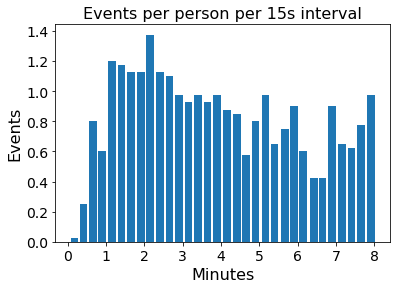

In [18]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, event) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.nodes()[player_id]['M']
        F = g.nodes()[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.nodes()[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.nodes()[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
            assert source in game['playerIds']  # check that source is another player
            if not g.nodes()[source]['M'].has_edge(*edge):  # check that clue is in source
                # this can fail if the exposer removes the clue while the exposed is dragging it.
                # turns out not to be a big deal
                print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['F'].edges()])
        assert should_have == has
       



ts = list(range(0,9*60,15))
events = 0
xs = []
events_list = []

for (player_id, g, t) in retrace(game):
    if t >= ts[0]:
        events_list.append(events)
        xs.append(t)
        ts.pop(0)
    events+=1


plt.bar(xs[1:], np.diff(events_list)/40, width=-12, align='edge')
plt.title("Events per person per 15s interval", fontsize=16)
plt.xlabel("Minutes", fontsize=16)
plt.ylabel("Events", fontsize=16)
plt.xticks(range(0, 481, 60), range(0,9), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0)